In [3]:
import os
from skimage import io, color
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter("runs/model3raw_ex1")
device = torch.device("cpu")

print(f"Using device: {device}")

class ImageNetDataset(Dataset):
    def __init__(self, root_dir, train=True, n_samples=1281167, transform=None, target_transform=None):
        self.root_dir = root_dir
        self.n_samples = n_samples
        self.train = train
        self.annotations_file = pd.read_csv(os.path.join(root_dir, "train.csv" if train else "test.csv"), header=None).sample(n=n_samples, ignore_index=True)
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return self.n_samples

    def __getitem__(self, idx: int):
        """Loads an image from a file, converts to LAB color space, and returns (L, [A; B])."""
        image_path = os.path.join(self.root_dir, self.annotations_file.iloc[idx, 0])

        rgb_img = io.imread(image_path)
        lab_img = color.rgb2lab(rgb_img)
        
        # split into L, A, B channels
        l, ab = lab_img[:, :, 0], lab_img[:, :, 1:]

        if self.transform:
            l = self.transform(l)
        if self.target_transform:
            ab = self.target_transform(ab)

        return l.float().to(device), ab.float().to(device)

root_dir = "./data/"
batch_size = 128
n_train = 1_000_000 # max 1281167
n_test = 5_000 # max 50000
transform = transforms.ToTensor()

train_set_size = int(n_train * 0.8)
val_set_size = n_train - train_set_size

full_set = ImageNetDataset(root_dir=root_dir, train=True, n_samples=n_train, transform=transform, target_transform=transform)
train_set, val_set = random_split(full_set, [train_set_size, val_set_size])
test_set = ImageNetDataset(root_dir=root_dir, train=False, n_samples=n_test, transform=transform, target_transform=transform)

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=True, num_workers=0)

l, ab = next(iter(train_loader))

class BaseModel(nn.Module):
	def __init__(self):
		super(BaseModel, self).__init__()

		self.l_cent = 50.
		self.l_norm = 100.
		self.ab_norm = 110.

	def normalize_l(self, in_l):
		return (in_l-self.l_cent)/self.l_norm

	def unnormalize_l(self, in_l):
		return in_l*self.l_norm + self.l_cent

	def normalize_ab(self, in_ab):
		return in_ab/self.ab_norm

	def unnormalize_ab(self, in_ab):
		return in_ab*self.ab_norm

class ImageColorizerModel(BaseModel):
    def __init__(self, classes=529):
        super(ImageColorizerModel, self).__init__()

        # Conv1
        self.model1 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1, bias=True),
            nn.ReLU(True),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1, bias=True),
            nn.ReLU(True),
            nn.BatchNorm2d(64),
        )

        # Conv2
        self.model2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1, bias=True),
            nn.ReLU(True),
            nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=1, bias=True),
            nn.ReLU(True),
            nn.BatchNorm2d(128),
        )

        # Conv3
        self.model3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1, bias=True),
            nn.ReLU(True),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=True),
            nn.ReLU(True),
            nn.Conv2d(256, 256, kernel_size=3, stride=2, padding=1, bias=True),
            nn.ReLU(True),
            nn.BatchNorm2d(256),
        )

        # Conv4
        self.model4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1, bias=True),
            nn.ReLU(True),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, bias=True),
            nn.ReLU(True),
            nn.Conv2d(512, 512, kernel_size=3, stride=2, padding=1, bias=True),
            nn.ReLU(True),
            nn.BatchNorm2d(512),
        )

        # Conv5
        self.model5 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, dilation=1, stride=1, padding=1, bias=True),
            nn.ReLU(True),
            nn.Conv2d(512, 512, kernel_size=3, dilation=1, stride=1, padding=1, bias=True),
            nn.ReLU(True),
            nn.Conv2d(512, 512, kernel_size=3, dilation=1, stride=1, padding=1, bias=True),
            nn.ReLU(True),
            nn.BatchNorm2d(512),
        )

        # Conv6
        self.model6 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, dilation=1, stride=1, padding=1, bias=True),
            nn.ReLU(True),
            nn.Conv2d(512, 512, kernel_size=3, dilation=1, stride=1, padding=1, bias=True),
            nn.ReLU(True),
            nn.Conv2d(512, 512, kernel_size=3, dilation=1, stride=1, padding=1, bias=True),
            nn.ReLU(True),
            nn.BatchNorm2d(512),
        )

        # Conv7
        self.model7 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, bias=True),
            nn.ReLU(True),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, bias=True),
            nn.ReLU(True),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, bias=True),
            nn.ReLU(True),
            nn.BatchNorm2d(512),
        )

        # Conv7
        self.model8 = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(512, 256, kernel_size=3, stride=1, padding=1, bias=True),
            nn.ReLU(True),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=True),
            nn.ReLU(True),
            nn.BatchNorm2d(256),
        )

        # Conv9
        self.model9 = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(256, 128, kernel_size=3, stride=1, padding=1, bias=True),
            nn.ReLU(True),
            nn.BatchNorm2d(128),
        )

        # Conv10
        self.model10 = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, kernel_size=3, dilation=1, stride=1, padding=1, bias=True),
            nn.LeakyReLU(negative_slope=.2),
        )

        # skip connection from conv3 to conv8
        self.skip3_8 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=1, dilation=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(256),
        )

        # skip connection from conv2 to conv9
        self.skip2_9 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=1, dilation=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(128),
        )

        # skip connection from conv1 to conv10
        self.skip1_10 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=1, dilation=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(64),
        )

        # regression output
        self.model_out = nn.Sequential(
            nn.Conv2d(64, 2, kernel_size=1, padding=0, dilation=1, stride=1, bias=True),
            nn.Tanh()
        )
        
    def forward(self, X):

        out1 = self.model1(X) # 64x64x64, also skip to conv10
        out2 = self.model2(out1) # 128x32x32, also skip to conv9
        out3 = self.model3(out2) # 256x16x16, also skip to conv8
        out4 = self.model4(out3) # 512x8x8
        out5 = self.model5(out4) # 512x8x8
        out6 = self.model6(out5) # 512x8x8
        out7 = self.model7(out6) # 512x8x8
        out8 = F.relu(self.model8(out7) + self.skip3_8(out3)) # 256x16x16
        out9 = F.relu(self.model9(out8) + self.skip2_9(out2)) # 128x32x32
        out10 = F.relu(self.model10(out9) + self.skip1_10(out1)) # 128x64x64
        out_reg = self.model_out(out10) # 2x64x64
        
        return self.unnormalize_ab(out_reg)

model = ImageColorizerModel().to(device)

Using device: cpu


In [4]:
model.load_state_dict(torch.load('model4_checkpoint_14_6000.pt', map_location="cpu")["model_state_dict"])
model.eval()

RuntimeError: PytorchStreamReader failed reading file data/2: invalid header or archive is corrupted

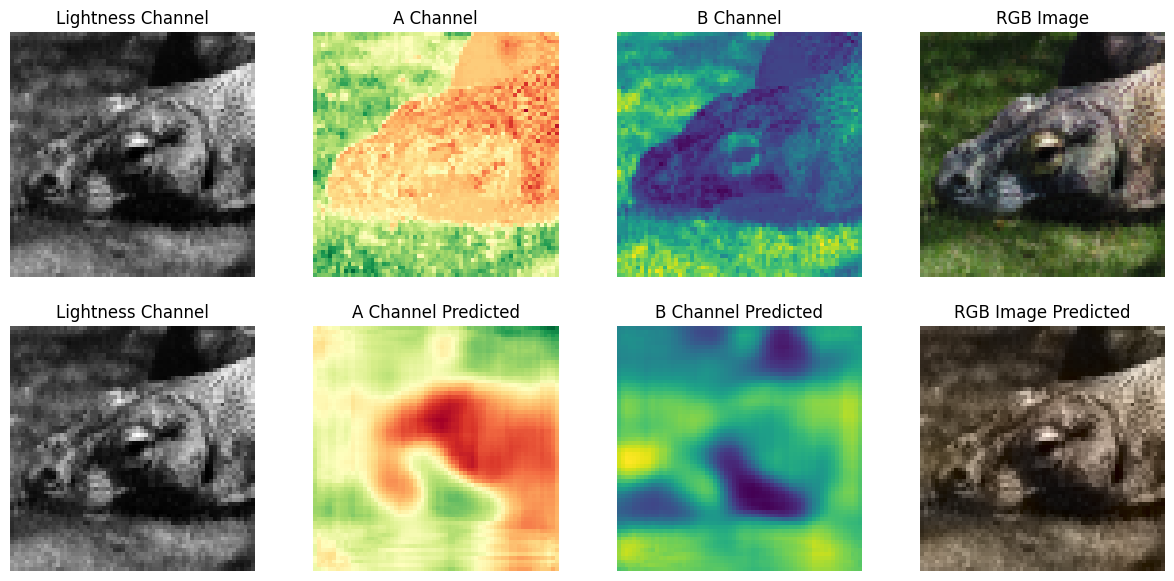

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import skimage

l, ab = next(iter(test_loader))

fig, ax = plt.subplots(2, 4, figsize=(15, 7))
ax[0, 0].imshow(l[0].squeeze().cpu(), cmap="gray")
ax[0, 0].set_title("Lightness Channel")
ax[0, 0].set_axis_off()

ax[0, 1].imshow(ab[0,0].cpu(), cmap="RdYlGn_r")
ax[0, 1].set_title("A Channel")
ax[0, 1].set_axis_off()

ax[0, 2].imshow(ab[0, 1].cpu())
ax[0, 2].set_title("B Channel")
ax[0, 2].set_axis_off()

# stack l and ab along the channel dimension (axis 0)
lab = np.concatenate((l[0].cpu().numpy(), ab[0].cpu().numpy()), axis=0).transpose(1, 2, 0)
rgb = color.lab2rgb(lab)

ax[0, 3].imshow(rgb, interpolation=None)
ax[0, 3].set_title("RGB Image")
ax[0, 3].set_axis_off()

ab_hat = model(l.to(device)).detach().cpu().numpy()
lab_hat = np.concatenate((l[0].cpu().numpy(), ab_hat[0]), axis=0).transpose(1, 2, 0)
rgb_hat = color.lab2rgb(lab_hat)

ax[1, 0].imshow(l[0].squeeze().cpu(), cmap="gray")
ax[1, 0].set_title("Lightness Channel")
ax[1, 0].set_axis_off()

ax[1, 1].imshow(ab_hat[0,0], cmap="RdYlGn_r")
ax[1, 1].set_title("A Channel Predicted")
ax[1, 1].set_axis_off()

ax[1, 2].imshow(ab_hat[0, 1])
ax[1, 2].set_title("B Channel Predicted")
ax[1, 2].set_axis_off()

ax[1, 3].imshow(rgb_hat, interpolation=None)
ax[1, 3].set_title("RGB Image Predicted")
ax[1, 3].set_axis_off()

